# Mid-Bootcamp Project - Classification

In [61]:
# import relevant libraries

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import getpass 
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, classification_report, plot_confusion_matrix

from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn import metrics
import scikitplot as skplt


import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency


In [2]:
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)

In [3]:
# pull data from mysql database into pandas dataframe

query = '''SELECT *
           FROM credit_card_data
           ;'''

data = pd.read_sql_query(query, engine)
data

Customer_Number Offer_Accepted     Reward Mailer_Type Income_Level  \
0                    1             No  Air Miles      Letter         High   
1                    2             No  Air Miles      Letter       Medium   
2                    3             No  Air Miles    Postcard         High   
3                    4             No  Air Miles      Letter       Medium   
4                    5             No  Air Miles      Letter       Medium   
...                ...            ...        ...         ...          ...   
17971            17996             No  Cash Back      Letter         High   
17972            17997             No  Cash Back      Letter         High   
17973            17998             No  Cash Back      Letter         High   
17974            17999             No  Cash Back      Letter       Medium   
17975            18000             No  Cash Back      Letter          Low   

       No_Bank_Accounts_Open Overdraft_Protection Credit_Rating  \
0                          1                   No          High   
1                          1                   No        Medium   
2                          2                   No        Medium   
3                          2                   No          High   
4                          1                   No        Medium   
...                      ...                  ...           ...   
17971                      1                   No           Low   
17972                      1                   No           Low   
17973                      1                   No           Low   
17974                      1                   No        Medium   
17975                      2                   No        Medium   

       No_Credit_Cards_Held  No_Homes_Owned  Household_Size Own_Your_Home  \
0                         2               1               4            No   
1                         2               2               5           Yes   
2                         2               1               2           Yes   
3                         1               1               4            No   
4                         2               1               6           Yes   
...                     ...             ...             ...           ...   
17971                     1               1               5           Yes   
17972                     3               1               3           Yes   
17973                     2               1               4            No   
17974                     4               2               2           Yes   
17975                     2               1               3            No   

       Average_Balance  Q1_Balance  Q2_Balance  Q3_Balance  
0              1160.75        1669         877        1095  
1               147.25          39         106          78  
2               276.50         367         352         145  
3              1219.00        1578        1760        1119  
4              1211.00        2140        1357         982  
...                ...         ...         ...         ...  
17971           167.50         136          65          71  
17972           850.50         984         940         943  
17973          1087.25         918         767        1170  
17974          1022.25         626         983         865  
17975          1056.00         265        1378        1978  

[17976 rows x 16 columns]

## Data cleaning & exploratory data analysis

In [4]:
# customer number can be used as the index

data = data.set_index('Customer_Number')

In [6]:
# standardise column names
# MAKE THIS A FUNCTION TO REUSE IN FUTURE - remove non alphanumeric characters too








In [8]:
data.columns= data.columns.str.strip().str.lower()
data.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'no_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'no_credit_cards_held', 'no_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance'],
      dtype='object')

In [9]:
data.shape, data.dtypes


((17976, 15),
 offer_accepted            object
 reward                    object
 mailer_type               object
 income_level              object
 no_bank_accounts_open      int64
 overdraft_protection      object
 credit_rating             object
 no_credit_cards_held       int64
 no_homes_owned             int64
 household_size             int64
 own_your_home             object
 average_balance          float64
 q1_balance                 int64
 q2_balance                 int64
 q3_balance                 int64
 dtype: object)

In [10]:
# check central tendencies and spread of data
# we can see that number of bank accounts, no of credit cards held & no of homes owned do not have much variance
# household size and the balance columns have some outliers at the higher end

summary = data.describe().T 
summary['iqr'] = summary['75%']-summary['25%'] 
summary = summary.apply(round)
summary

count    mean    std   min    25%     50%     75%  \
no_bank_accounts_open  17976.0     1.0    0.0   1.0    1.0     1.0     1.0   
no_credit_cards_held   17976.0     2.0    1.0   1.0    1.0     2.0     2.0   
no_homes_owned         17976.0     1.0    0.0   1.0    1.0     1.0     1.0   
household_size         17976.0     3.0    1.0   1.0    3.0     3.0     4.0   
average_balance        17976.0   941.0  350.0  48.0  788.0  1007.0  1153.0   
q1_balance             17976.0   910.0  620.0   0.0  393.0   772.0  1521.0   
q2_balance             17976.0   999.0  457.0   0.0  663.0  1032.0  1342.0   
q3_balance             17976.0  1042.0  553.0   0.0  633.0   946.0  1463.0   

                          max     iqr  
no_bank_accounts_open     3.0     0.0  
no_credit_cards_held      4.0     1.0  
no_homes_owned            3.0     0.0  
household_size            9.0     1.0  
average_balance        3366.0   366.0  
q1_balance             3450.0  1128.0  
q2_balance             3421.0   679.0  
q3_balance             3823.0   830.0

In [11]:
# check for nulls - luckily there are none here :)

data.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
no_bank_accounts_open    0
overdraft_protection     0
credit_rating            0
no_credit_cards_held     0
no_homes_owned           0
household_size           0
own_your_home            0
average_balance          0
q1_balance               0
q2_balance               0
q3_balance               0
dtype: int64

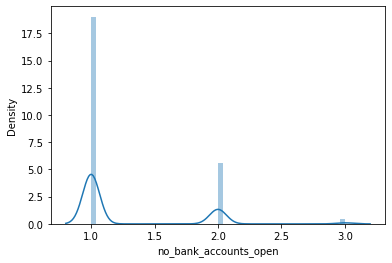

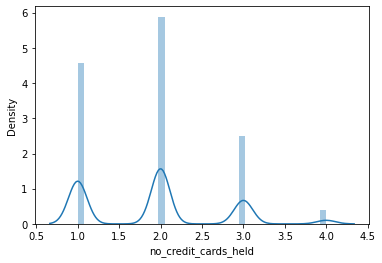

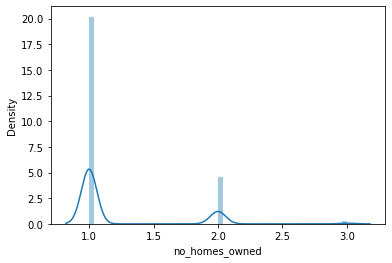

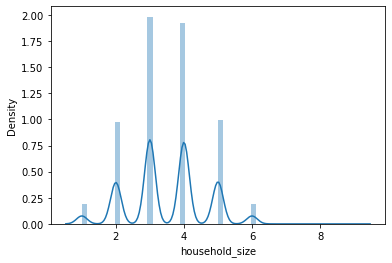

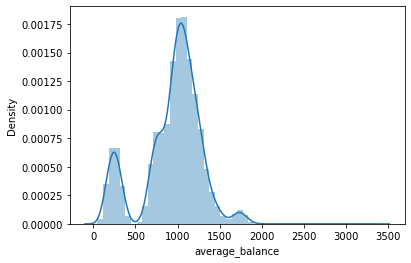

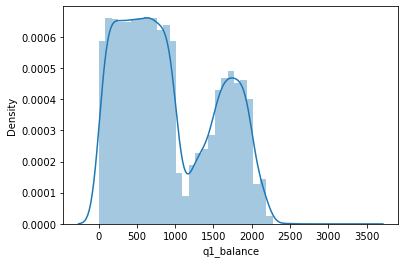

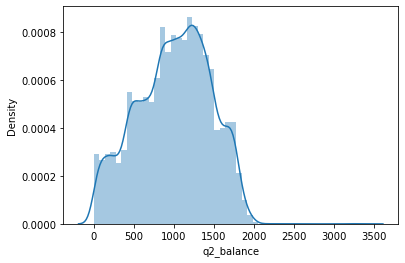

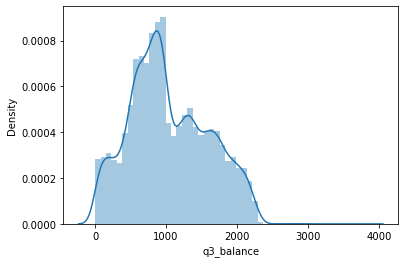

In [12]:
# check distribution of numerical columns 
# balance columns could use a log transform or box cox to make the distribution more normal

for col in data.select_dtypes(np.number):
    sns.distplot(data[col])
    plt.show()

In [13]:
# check counts of categorical variables per column
# in general the different categorical variables are evenly distributed except our target variable offer_accepted and overdraft_protection and own_yor_own_home

for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

no     16955
yes     1021
Name: offer_accepted, dtype: int64 

air miles    6047
cash back    5995
points       5934
Name: reward, dtype: int64 

postcard    9134
letter      8842
Name: mailer_type, dtype: int64 

medium    9002
high      4519
low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



In [14]:
for col in data.select_dtypes(include='object'):
    px.histogram(data[col],width=500, height=400).show()

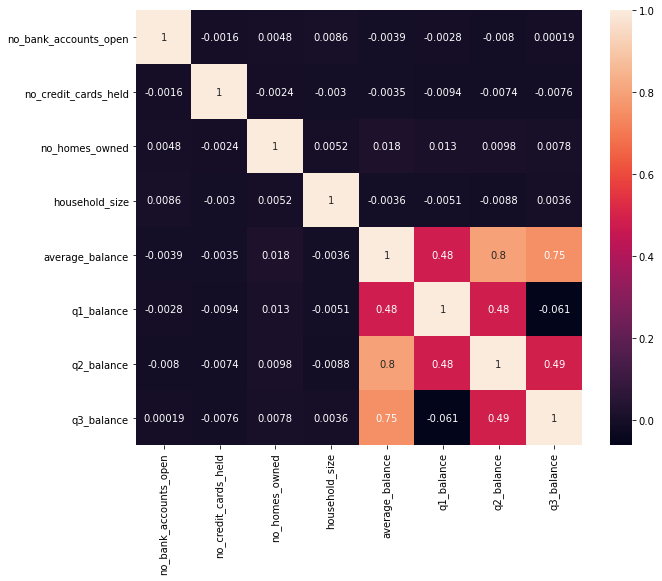

In [15]:
# check correlation of data
# based on this I would drop Q1, Q2 & Q3 balance as they have high multicollinearity and we have the average balance anyway

corr_matrix=data.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [16]:
# let's check the VIF too

data1 = data.copy()
numericals = data1.select_dtypes(np.number)

In [17]:
# add constant to numerical variables

vif_numericals = add_constant(numericals)
vif_numericals

const  no_bank_accounts_open  no_credit_cards_held  \
Customer_Number                                                       
1                  1.0                      1                     2   
2                  1.0                      1                     2   
3                  1.0                      2                     2   
4                  1.0                      2                     1   
5                  1.0                      1                     2   
...                ...                    ...                   ...   
17996              1.0                      1                     1   
17997              1.0                      1                     3   
17998              1.0                      1                     2   
17999              1.0                      1                     4   
18000              1.0                      2                     2   

                 no_homes_owned  household_size  average_balance  q1_balance  \
Customer_Number                                                                
1                             1               4          1160.75        1669   
2                             2               5           147.25          39   
3                             1               2           276.50         367   
4                             1               4          1219.00        1578   
5                             1               6          1211.00        2140   
...                         ...             ...              ...         ...   
17996                         1               5           167.50         136   
17997                         1               3           850.50         984   
17998                         1               4          1087.25         918   
17999                         2               2          1022.25         626   
18000                         1               3          1056.00         265   

                 q2_balance  q3_balance  
Customer_Number                          
1                       877        1095  
2                       106          78  
3                       352         145  
4                      1760        1119  
5                      1357         982  
...                     ...         ...  
17996                    65          71  
17997                   940         943  
17998                   767        1170  
17999                   983         865  
18000                  1378        1978  

[17976 rows x 9 columns]

In [18]:
# prints table with VIF per column
# average balance is the column we need to investigate I think - has a VIF factor of almost 10
# as shown in the correlation matrix heatmap above q1, q2 and q3 balance all has high multicollinearity - drop them and check VIF of average_balance after

vif = pd.DataFrame(index=vif_numericals.columns)
vif["VIF Factor"] = [round(variance_inflation_factor(np.array(vif_numericals), i),2)
                     for i in range(len(vif_numericals.columns))]
vif

VIF Factor
const                       38.52
no_bank_accounts_open        1.00
no_credit_cards_held         1.00
no_homes_owned               1.00
household_size               1.00
average_balance              9.84
q1_balance                   2.83
q2_balance                   3.04
q3_balance                   5.29

In [19]:
# let's check the VIF if we remove the q balance columns

numericals_2 = data1.select_dtypes(np.number)
numericals_2 = numericals_2.drop(columns=['q1_balance','q2_balance','q3_balance'])
numericals_2

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     4               2   
18000                                2                     2               1   

                 household_size  average_balance  
Customer_Number                                   
1                             4          1160.75  
2                             5           147.25  
3                             2           276.50  
4                             4          1219.00  
5                             6          1211.00  
...                         ...              ...  
17996                         5           167.50  
17997                         3           850.50  
17998                         4          1087.25  
17999                         2          1022.25  
18000                         3          1056.00  

[17976 rows x 5 columns]

In [20]:
# VIF of average_balance is now 1 - showing the q balance columns were highly correlated with average balance

vif_numericals_2 = add_constant(numericals_2)
vif_2 = pd.DataFrame(index=vif_numericals_2.columns)
vif_2["VIF Factor"] = [round(variance_inflation_factor(np.array(vif_numericals_2), i),2)
                     for i in range(len(vif_numericals_2.columns))]
vif_2


VIF Factor
const                       38.45
no_bank_accounts_open        1.00
no_credit_cards_held         1.00
no_homes_owned               1.00
household_size               1.00
average_balance              1.00

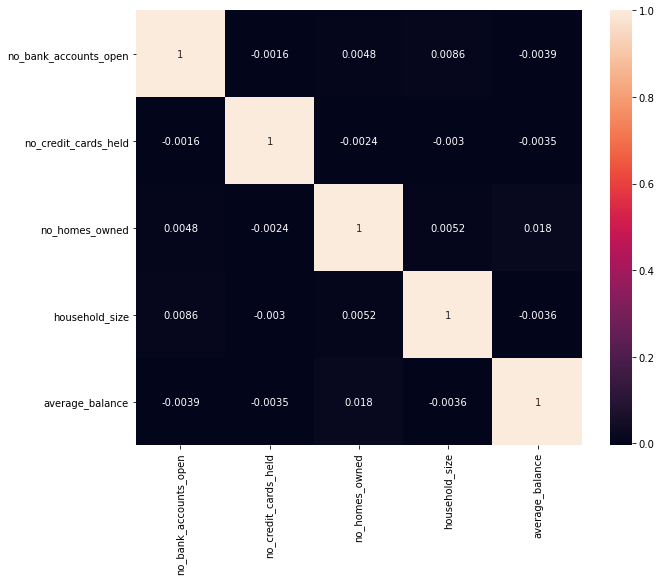

In [21]:
# correlation matrix now shows no high multicollinearity

corr_matrix=numericals_2.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [36]:
# drop columns in main dataframe

data = data.drop(columns=['q1_balance','q2_balance','q3_balance'])
data

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           no  air miles      letter         high   
2                           no  air miles      letter       medium   
3                           no  air miles    postcard         high   
4                           no  air miles      letter       medium   
5                           no  air miles      letter       medium   
...                        ...        ...         ...          ...   
17996                       no  cash back      letter         high   
17997                       no  cash back      letter         high   
17998                       no  cash back      letter         high   
17999                       no  cash back      letter       medium   
18000                       no  cash back      letter          low   

                 no_bank_accounts_open overdraft_protection credit_rating  \
Customer_Number                                                             
1                                    1                   No          High   
2                                    1                   No        Medium   
3                                    2                   No        Medium   
4                                    2                   No          High   
5                                    1                   No        Medium   
...                                ...                  ...           ...   
17996                                1                   No           Low   
17997                                1                   No           Low   
17998                                1                   No           Low   
17999                                1                   No        Medium   
18000                                2                   No        Medium   

                 no_credit_cards_held  no_homes_owned  household_size  \
Customer_Number                                                         
1                                   2               1               4   
2                                   2               2               5   
3                                   2               1               2   
4                                   1               1               4   
5                                   2               1               6   
...                               ...             ...             ...   
17996                               1               1               5   
17997                               3               1               3   
17998                               2               1               4   
17999                               4               2               2   
18000                               2               1               3   

                own_your_home  average_balance  
Customer_Number                                 
1                          No          1160.75  
2                         Yes           147.25  
3                         Yes           276.50  
4                          No          1219.00  
5                         Yes          1211.00  
...                       ...              ...  
17996                     Yes           167.50  
17997                     Yes           850.50  
17998                      No          1087.25  
17999                     Yes          1022.25  
18000                      No          1056.00  

[17976 rows x 12 columns]

In [37]:
# chi squared test
# let's start with income level vs own your home

data_crosstab = pd.crosstab(data['income_level'], data['own_your_home'], margins=True)
data_crosstab

own_your_home    No    Yes    All
income_level                     
high           1634   2885   4519
low            1551   2904   4455
medium         3155   5847   9002
All            6340  11636  17976

In [38]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab)
p_value

0.9042671099694827

In [39]:
chi2_contingency(data_crosstab, correction=False)

# no correlation - we need a chi square score of 12 for there to be a relationship

(2.1614506239053406,
 0.9042671099694827,
 6,
 array([[ 1593.81731197,  2925.18268803,  4519.        ],
        [ 1571.24499332,  2883.75500668,  4455.        ],
        [ 3174.9376947 ,  5827.0623053 ,  9002.        ],
        [ 6340.        , 11636.        , 17976.        ]]))

In [40]:
# income level vs credit rating

data_crosstab_2 = pd.crosstab(data['income_level'], data['credit_rating'], margins=True)
data_crosstab_2

credit_rating  High   Low  Medium    All
income_level                            
high           1512  1526    1481   4519
low            1539  1439    1477   4455
medium         3013  2983    3006   9002
All            6064  5948    5964  17976

In [41]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab_2)
p_value

0.9651046686244021

In [42]:
chi2_contingency(data_crosstab_2, correction=False)

# no correlation - need chi sqaure score of around 17


(2.9794361727435366,
 0.9651046686244021,
 9,
 array([[ 1524.43346684,  1495.27214063,  1499.29439252,  4519.        ],
        [ 1502.84379172,  1474.09546061,  1478.06074766,  4455.        ],
        [ 3036.72274143,  2978.63239875,  2986.64485981,  9002.        ],
        [ 6064.        ,  5948.        ,  5964.        , 17976.        ]]))

## 1st run - fitting logistic regression model

In [58]:
# let's fit the logistic regression model now with no changes to the data - just for benchmarking

y = data['offer_accepted']
X = data.drop('offer_accepted', axis=1)

In [60]:
# encode categoricals

X = pd.get_dummies(X)
X

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     4               2   
18000                                2                     2               1   

                 household_size  average_balance  reward_Air Miles  \
Customer_Number                                                      
1                             4          1160.75                 1   
2                             5           147.25                 1   
3                             2           276.50                 1   
4                             4          1219.00                 1   
5                             6          1211.00                 1   
...                         ...              ...               ...   
17996                         5           167.50                 0   
17997                         3           850.50                 0   
17998                         4          1087.25                 0   
17999                         2          1022.25                 0   
18000                         3          1056.00                 0   

                 reward_Cash Back  reward_Points  mailer_type_Letter  \
Customer_Number                                                        
1                               0              0                   1   
2                               0              0                   1   
3                               0              0                   0   
4                               0              0                   1   
5                               0              0                   1   
...                           ...            ...                 ...   
17996                           1              0                   1   
17997                           1              0                   1   
17998                           1              0                   1   
17999                           1              0                   1   
18000                           1              0                   1   

                 mailer_type_Postcard  income_level_High  income_level_Low  \
Customer_Number                                                              
1                                   0                  1                 0   
2                                   0                  0                 0   
3                                   1                  1                 0   
4                                   0                  0                 0   
5                                   0                  0                 0   
...                               ...                ...               ...   
17996                               0                  1                 0   
17997                               0                  1                 0   
17998                               0                  1                 0   
17999                               0                  0                 0   
18000                               0                  0                 1   

                 income_level_Medium  overdraft_protection_No  \
Customer_Number                                 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [66]:
classification.score(X_test, y_test)

0.9468854282536151

In [67]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3405,    0],
       [ 191,    0]])

<AxesSubplot:>

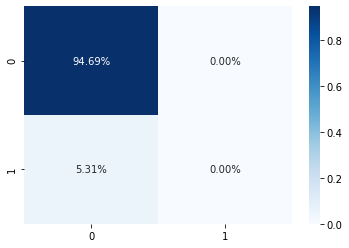

In [75]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues')

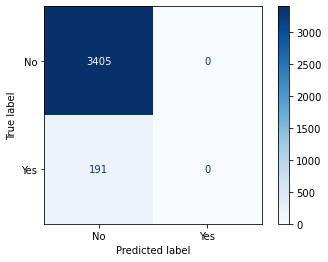

In [70]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

## Conclusions after first run
- Model predicted 0 negatives (either falsely or correctly)
- There is therefore a big problem with predicting the minority class - we need to deal with the data imbalance

## 2nd run 
- deal with outliers and data imbalance and run model again to try improve performance on minority class

In [43]:
data_copy = data.copy()

for col in data_copy.select_dtypes(np.number):
    px.box(data_copy[col],width=500, height=500).show()

# the box plots show we have outliers in all of the columns

In [44]:
# function to winsorize the relevant columns to remove outliers

def winsorizer(df,cols=[]):
    for col in cols:
        df[col] = winsorize(df[col],limits=[0.1,0.2])
    return df
    

In [45]:
winsorizer(data_copy,cols=data_copy[['household_size','average_balance','no_credit_cards_held']])

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           no  air miles      letter         high   
2                           no  air miles      letter       medium   
3                           no  air miles    postcard         high   
4                           no  air miles      letter       medium   
5                           no  air miles      letter       medium   
...                        ...        ...         ...          ...   
17996                       no  cash back      letter         high   
17997                       no  cash back      letter         high   
17998                       no  cash back      letter         high   
17999                       no  cash back      letter       medium   
18000                       no  cash back      letter          low   

                 no_bank_accounts_open overdraft_protection credit_rating  \
Customer_Number                                                             
1                                    1                   No          High   
2                                    1                   No        Medium   
3                                    2                   No        Medium   
4                                    2                   No          High   
5                                    1                   No        Medium   
...                                ...                  ...           ...   
17996                                1                   No           Low   
17997                                1                   No           Low   
17998                                1                   No           Low   
17999                                1                   No        Medium   
18000                                2                   No        Medium   

                 no_credit_cards_held  no_homes_owned  household_size  \
Customer_Number                                                         
1                                   2               1               4   
2                                   2               2               4   
3                                   2               1               2   
4                                   1               1               4   
5                                   2               1               4   
...                               ...             ...             ...   
17996                               1               1               4   
17997                               3               1               3   
17998                               2               1               4   
17999                               3               2               2   
18000                               2               1               3   

                own_your_home  average_balance  
Customer_Number                                 
1                          No          1160.75  
2                         Yes           288.25  
3                         Yes           288.25  
4                          No          1192.75  
5                         Yes          1192.75  
...                       ...              ...  
17996                     Yes           288.25  
17997                     Yes           850.50  
17998                      No          1087.25  
17999                     Yes          1022.25  
18000                      No          1056.00  

[17976 rows x 12 columns]

In [46]:
px.box(data_copy['average_balance'],width=500,height=500).show()

In [47]:
px.box(data_copy['household_size'],width=500,height=500).show()

In [31]:
# deal with data imbalance 
# try 2 methods

In [48]:
data_copy['offer_accepted'].value_counts()

no     16955
yes     1021
Name: offer_accepted, dtype: int64

In [49]:
y = data_copy['offer_accepted']
X = data_copy.drop('offer_accepted', axis=1)

In [50]:
X = pd.get_dummies(X)
X

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     3               2   
18000                                2                     2               1   

                 household_size  average_balance  reward_air miles  \
Customer_Number                                                      
1                             4          1160.75                 1   
2                             4           288.25                 1   
3                             2           288.25                 1   
4                             4          1192.75                 1   
5                             4          1192.75                 1   
...                         ...              ...               ...   
17996                         4           288.25                 0   
17997                         3           850.50                 0   
17998                         4          1087.25                 0   
17999                         2          1022.25                 0   
18000                         3          1056.00                 0   

                 reward_cash back  reward_points  mailer_type_letter  \
Customer_Number                                                        
1                               0              0                   1   
2                               0              0                   1   
3                               0              0                   0   
4                               0              0                   1   
5                               0              0                   1   
...                           ...            ...                 ...   
17996                           1              0                   1   
17997                           1              0                   1   
17998                           1              0                   1   
17999                           1              0                   1   
18000                           1              0                   1   

                 mailer_type_postcard  income_level_high  income_level_low  \
Customer_Number                                                              
1                                   0                  1                 0   
2                                   0                  0                 0   
3                                   1                  1                 0   
4                                   0                  0                 0   
5                                   0                  0                 0   
...                               ...                ...               ...   
17996                               0                  1                 0   
17997                               0                  1                 0   
17998                               0                  1                 0   
17999                               0                  0                 0   
18000                               0                  0                 1   

                 income_level_medium  overdraft_protection_No  \
Customer_Number                                 

In [51]:

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

yes    16955
no     16955
Name: offer_accepted, dtype: int64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [57]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [58]:
classification.score(X_test, y_test)

0.9284871719256856

In [59]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3307,   85],
       [ 400, 2990]])

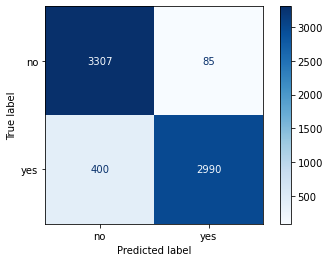

In [62]:
plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

In [65]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          no       0.89      0.97      0.93      3392
         yes       0.97      0.88      0.92      3390

    accuracy                           0.93      6782
   macro avg       0.93      0.93      0.93      6782
weighted avg       0.93      0.93      0.93      6782



In [77]:
# let's check the metrics for 'yes' - the minority class
# precision score - what proportion of postive predictions (yes predictions) were actually correct? -  of all the rows predicted to be a yes, 97% were actually a yes 
# recall score - what proportion of actual yes were correctly predicted ? of all the 'yes' rows - 88% were predicted correctly

print(f'Precision score: {precision_score(y_test,predictions,pos_label="yes")}')
print(f'Recall score: {recall_score(y_test,predictions,pos_label="yes")}')

Precision score: 0.9723577235772358
Recall score: 0.8820058997050148


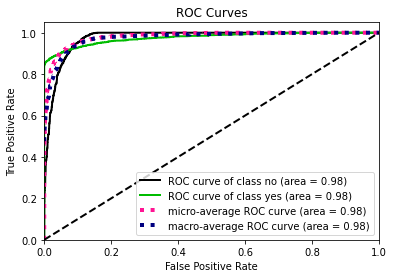

In [87]:

y_probas = classification.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

### Conclusions after second run using smote
- accuracy score slightly worse but much better performance on minorty class after using smote method to deal with class imbalance
- ROC score is 0.98
- Recall (correctly identified true positives) 0.88 - model performing much better at correctly identifying yes (the first run we had 0 predicted yes)
- Precision (ration of true positives to all positives) 0.97 -  very high proportion of actual yes were correctly predicted
- still a small amount of false negatives we could work on to improve recall score 
- check bias/variance?

## 3rd run - this time using downsampling